### ISSUES and TODOs

- see `README.md`

In [1]:
import torch, os, argparse, json, copy

import pandas as pd
import numpy as np
from termcolor import cprint

from tqdm import tqdm
from datetime import datetime
from utils import _logger, set_requires_grad
from model import *
from utils import _calc_metrics, copy_Files
from loss import * # base_Model, base_Model_F, target_classifier
from datetime import datetime

from dataloader_old import data_generator
from trainer import Trainer, model_finetune, model_test, model_pretrain
from pprint import pprint


from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    average_precision_score,
    accuracy_score,
    precision_score,
    f1_score,
    recall_score,
)

# For Arial
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams["text.usetex"] = False

# for latex:
# matplotlib.rcParams['font.family'] = "DejaVu Sans"
# matplotlib.rcParams['font.serif'] = "Computer Modern"
# matplotlib.rcParams["text.usetex"] = True

matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["axes.labelsize"] = 22
matplotlib.rcParams["xtick.labelsize"] = 22
matplotlib.rcParams["ytick.labelsize"] = 22
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams["legend.fontsize"] = 22
matplotlib.rcParams["axes.titlesize"] = 22
matplotlib.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["figure.autolayout"] = True

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


print(f'CUDA available: {torch.cuda.is_available()}')

device_count = torch.cuda.device_count()
for i in range(device_count):
    torch.cuda.set_device(i)
    cur_device_id = torch.cuda.current_device()
    cur_device_name = torch.cuda.get_device_name(cur_device_id)
    print(f'Current device:\nID {cur_device_id} | Name: {cur_device_name}')
    print(f'supported arch list: {torch.cuda.get_arch_list()}\n')
    
bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'


CUDA available: True
Current device:
ID 0 | Name: RTX A6000
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Current device:
ID 1 | Name: Quadro P2200
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']



In [2]:
!pwd

/home/roman/CODE/tachikoma-analysis/TF-C/code


In [3]:
a = torch.load('../datasets/Epilepsy/test.pt')
a.keys()

dict_keys(['samples', 'labels'])

In [4]:
a['labels'].unique()

tensor([0, 1])

In [5]:
a['samples'].shape

torch.Size([11420, 1, 178])

In [6]:
11420/60

190.33333333333334

In [3]:
run_description = 'run1'
SEED = 0
training_mode = 'pre_train'   # 'fine_tune_test'


sourcedata = 'SleepEEG' # 'FD_A', 'HAR', 'ECG'
targetdata = 'Epilepsy'   # 'Epilepsy, 'FD_B', 'Gesture', 'EMG'


logs_save_dir = 'experiments_logs'
device = 'cuda:1'
experiment_description = str(sourcedata) + '_2_' + str(targetdata)
method = 'Time-Freq Consistency' # 'TS-TCC'


home_dir = os.getcwd()
home_path = home_dir
os.makedirs(logs_save_dir, exist_ok=True)

exec(f'from config_files.{sourcedata}_Configs import Config as Configs')
configs = Configs() # THis is OK???
pprint({i:configs.__getattribute__(i) for i in dir(configs) if not i.startswith('__')})

{'CNNoutput_channel': 10,
 'Context_Cont': <config_files.SleepEEG_Configs.Context_Cont_configs object at 0x7fd8945bd7f0>,
 'TC': <config_files.SleepEEG_Configs.TC object at 0x7fd894575820>,
 'TSlength_aligned': 178,
 'augmentation': <config_files.SleepEEG_Configs.augmentations object at 0x7fd894575940>,
 'batch_size': 128,
 'beta1': 0.9,
 'beta2': 0.99,
 'drop_last': True,
 'dropout': 0.35,
 'features_len': 127,
 'features_len_f': 127,
 'final_out_channels': 128,
 'increased_dim': 1,
 'input_channels': 1,
 'kernel_size': 25,
 'lr': 0.0003,
 'lr_f': 0.0003,
 'num_classes': 5,
 'num_classes_target': 2,
 'num_epoch': 40,
 'optimizer': 'adam',
 'stride': 3,
 'target_batch_size': 60}


In [8]:
# check datasets

path = '../datasets/'
dataset_folders = os.listdir(path)
stats = []
for dataset_folder in dataset_folders:
    ds = torch.load(os.path.join(path, dataset_folder, "train.pt"))
    stats.append({'name': dataset_folder, 'shape': list(ds['samples'].shape)})
stats = pd.DataFrame(stats)
stats
    

,name,shape
0,HAR,"[5881, 3, 206]"
1,ECG,"[43673, 1, 1500]"
2,FD-B,"[60, 1, 5120]"
3,Gesture,"[320, 3, 206]"
4,SleepEEG,"[371055, 1, 178]"
5,EMG,"[122, 1, 1500]"
6,Epilepsy,"[60, 1, 178]"
7,FD-A,"[8184, 1, 5120]"


### Epilepsy
- single-channel
- 500 subjects. 
- 23.6 seconds for each subject.
- 11,500 samples of 1 second each, 
- srate = 178 Hz

### SleepEEG
- 153 whole-night sleeping EEG recordings produced
- 82 healthy subjects
- 1-channel EEG signal is sampled at 100 Hz. 
- We segment the EEG signals into segments (window size is 200) without overlapping,
- labels: 5 sleeping stages: Wake (W), NREM (N1, N2, N3), REM.
- 371,055 EEG samples

### Dataset and Dataloaders
- work with multi-channel data

In [251]:
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [4]:
experiment_log_dir = os.path.join(logs_save_dir, experiment_description, run_description, str(training_mode) + f"_seed_{SEED}")
os.makedirs(experiment_log_dir, exist_ok=True)


In [5]:
experiment_log_dir

'experiments_logs/SleepEEG_2_Epilepsy/run1/pre_train_seed_0'

In [6]:
# Logging
start_time = datetime.now()
log_file_name = os.path.join(experiment_log_dir, f"logs_{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}.log")
# 'experiments_logs/Exp1/run1/train_linear_seed_0/logs_14_04_2022_15_13_12.log'
logger = _logger(log_file_name)

# Load datasets. Only self-supervised learning needs augmentation.
sourcedata_path = f"../datasets/{sourcedata}"
targetdata_path = f"../datasets/{targetdata}"

logger.debug("=" * 45)
logger.debug(f'Pre-training Dataset: {sourcedata}')
logger.debug(f'Target (fine-tuning) Dataset: {targetdata}')
logger.debug(f'Method:  {method}')
logger.debug(f'Mode:    {training_mode}')
logger.debug(f'sourcedata_path:    {sourcedata_path}')
logger.debug(f'targetdata_path:    {targetdata_path}')
logger.debug("=" * 45)

Pre-training Dataset: SleepEEG
Target (fine-tuning) Dataset: Epilepsy
Method:  Time-Freq Consistency
Mode:    pre_train
sourcedata_path:    ../datasets/SleepEEG
targetdata_path:    ../datasets/Epilepsy


In [8]:
dataset = torch.load(os.path.join(sourcedata_path, "train.pt"))
dataset['samples'].shape

torch.Size([371055, 1, 178])

In [9]:
X_train = dataset["samples"]
y_train = dataset["labels"]
cprint(X_train.shape, 'green')

# shuffle
data = list(zip(X_train, y_train))
np.random.shuffle(data)
X_train, y_train = zip(*data)
X_train, y_train = torch.stack(list(X_train), dim=0), torch.stack(list(y_train), dim=0)
cprint(X_train.shape, 'blue')


torch.Size([371055, 1, 178])
torch.Size([371055, 1, 178])


In [10]:
if len(X_train.shape) < 3:
    X_train = X_train.unsqueeze(2)

if X_train.shape.index(min(X_train.shape)) != 1:  # make sure the Channels in second dim
    X_train = X_train.permute(0, 2, 1)
"""Align the TS length between source and target datasets"""

X_train = X_train[:, :, :int(configs.TSlength_aligned)]  # take the first 178 samples

X_train.shape

torch.Size([371055, 1, 178])

In [11]:
from augmentations import DataTransform_FD, DataTransform_TD
import torch.fft as fft


X_train_f = fft.fft(X_train).abs()  #/(window_length) # rfft for real value inputs.


# if training_mode == "pre_train":  # no need to apply Augmentations in other modes
#     aug1 = DataTransform_TD(x_data, config)
#     aug1_f = DataTransform_FD(x_data_f, config)  # [7360, 1, 90]

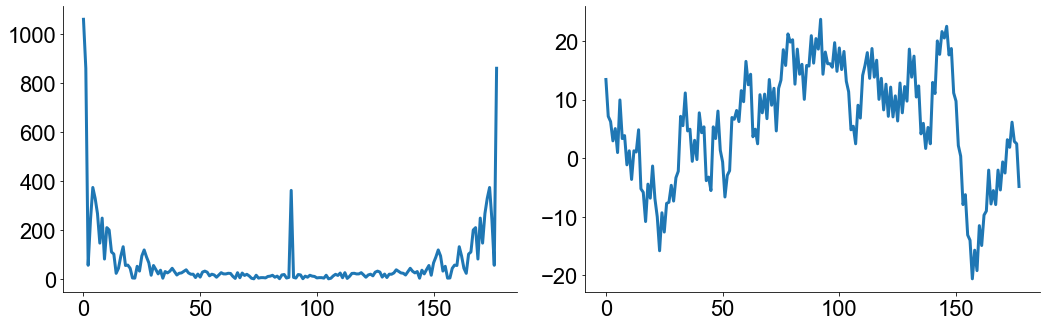

In [259]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))


ax0.plot(X_train_f[0,0,:].squeeze().numpy())
ax1.plot(X_train[0,0,:].squeeze().numpy())


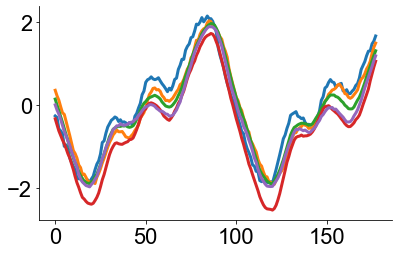

In [260]:
for i in range(5):
    plt.plot(X_train[torch.where(y_train == i)[0], :,: ].mean(axis=0).squeeze())

In [261]:
training_mode

'pre_train'

In [23]:
# build dataloaders

subset = False # use a subset for debugging.

print(f'sourcedata_path: {sourcedata_path}')
print(f'targetdata_path: {targetdata_path}')
train_dl, valid_dl, test_dl = data_generator(sourcedata_path, targetdata_path,
                                             configs,
                                             training_mode,
                                             subset=subset)

# made from source dataset:
# train_dl - (pretraining DS from one domain, e.g. sleep)

# made from target dataset:
# valid_dl 
# test_dl

sourcedata_path: ../datasets/SleepEEG
targetdata_path: ../datasets/Epilepsy


In [263]:
# on each iteration, dataloader returns a batch, which is 
# a 5-tuple (orig_TD, label, aug_TD, orig_freq, aug_freq)
# of 3-d tensors

i = iter(train_dl)
print(f'Number of batches in the dataloader: {len(i)}')
b = next(i)
print(f'Size of tuple returned in each batch: {len(b)}')
pprint({name: tens.shape for name, tens in zip(('orig_TD', 'label', 'aug_TD', 'orig_freq', 'aug_freq'), b)})

Number of batches in the dataloader: 2898
Size of tuple returned in each batch: 5
{'aug_TD': torch.Size([128, 1, 178]),
 'aug_freq': torch.Size([128, 1, 178]),
 'label': torch.Size([128]),
 'orig_TD': torch.Size([128, 1, 178]),
 'orig_freq': torch.Size([128, 1, 178])}


In [41]:
2898*128

370944

In [38]:
# on each iteration, dataloader returns a batch, which is 
# a 5-tuple (orig_TD, label, aug_TD, orig_freq, aug_freq)
# of 3-d tensors

i = iter(valid_dl)
print(f'Number of batches in the dataloader: {len(i)}')
b = next(i)
print(f'Size of tuple returned in each batch: {len(b)}')
pprint({name: tens.shape for name, tens in zip(('orig_TD', 'label', 'aug_TD', 'orig_freq', 'aug_freq'), b)})

Number of batches in the dataloader: 1
Size of tuple returned in each batch: 5
{'aug_TD': torch.Size([60, 1, 178]),
 'aug_freq': torch.Size([60, 1, 178]),
 'label': torch.Size([60]),
 'orig_TD': torch.Size([60, 1, 178]),
 'orig_freq': torch.Size([60, 1, 178])}


In [39]:
# on each iteration, dataloader returns a batch, which is 
# a 5-tuple (orig_TD, label, aug_TD, orig_freq, aug_freq)
# of 3-d tensors

i = iter(test_dl)
print(f'Number of batches in the dataloader: {len(i)}')
b = next(i)
print(f'Size of tuple returned in each batch: {len(b)}')
pprint({name: tens.shape for name, tens in zip(('orig_TD', 'label', 'aug_TD', 'orig_freq', 'aug_freq'), b)})

Number of batches in the dataloader: 190
Size of tuple returned in each batch: 5
{'aug_TD': torch.Size([60, 1, 178]),
 'aug_freq': torch.Size([60, 1, 178]),
 'label': torch.Size([60]),
 'orig_TD': torch.Size([60, 1, 178]),
 'orig_freq': torch.Size([60, 1, 178])}


In [43]:
# Load Model 
"""Here are two models, one basemodel, another is temporal contrastive model"""

TFC_model = TFC(configs).to(device)
classifier = target_classifier(configs).to(device)

cprint(TFC_model, color='grey')

cprint(classifier, color='red')

TFC(
  (conv_block1_t): Sequential(
    (0): Conv1d(1, 32, kernel_size=(25,), stride=(3,), padding=(12,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (conv_block2_t): Sequential(
    (0): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block3_t): Sequential(
    (0): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (projector_t): Sequential(
    (0):

In [38]:
# load model parameters
TFC_model.load_state_dict(torch.load('TFC_model.wts'))

<All keys matched successfully>

In [44]:
model_optimizer = torch.optim.Adam(TFC_model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)


In [21]:
# Trainer

if training_mode == "pre_train":  # to do it only once
    copy_Files(os.path.join(logs_save_dir, experiment_description, run_description), sourcedata)

In [22]:
with open('loss', 'r') as f:
    lines = f.readlines()
    dicts = [json.loads(i[:-1]) for i in lines]
df = pd.DataFrame(dicts)
df.plot(y=['loss_t', 'loss_f', 'l_TF', 'l_1', 'l_2', 'l_3'])

FileNotFoundError: [Errno 2] No such file or directory: 'loss'

In [15]:
print(TFC_model.conv_block1_t)
print(TFC_model.conv_block1_f)

Sequential(
  (0): Conv1d(1, 32, kernel_size=(25,), stride=(3,), padding=(12,), bias=False)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.35, inplace=False)
)
Sequential(
  (0): Conv1d(1, 32, kernel_size=(25,), stride=(3,), padding=(12,), bias=False)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.35, inplace=False)
)


In [269]:
# get number of parameters
a = 0
for p in TFC_model.parameters():
    a += p.flatten().shape[0]
print(f'number of parameters in model: {a}')
    
a = 0

classifier = target_classifier(configs).to(device)
for p in classifier.parameters():
    a += p.flatten().shape[0]
print(f'number of parameters in classifier: {a}')

number of parameters in model: 889024
number of parameters in classifier: 16578


In [20]:
# original, label, augmented, orig_freq, aug_freq
a = next(iter(train_dl))
a[0].shape

torch.Size([128, 1, 178])

In [24]:
train_dl_iter = iter(train_dl)

CPU times: user 33.8 ms, sys: 4.47 ms, total: 38.3 ms
Wall time: 36.7 ms


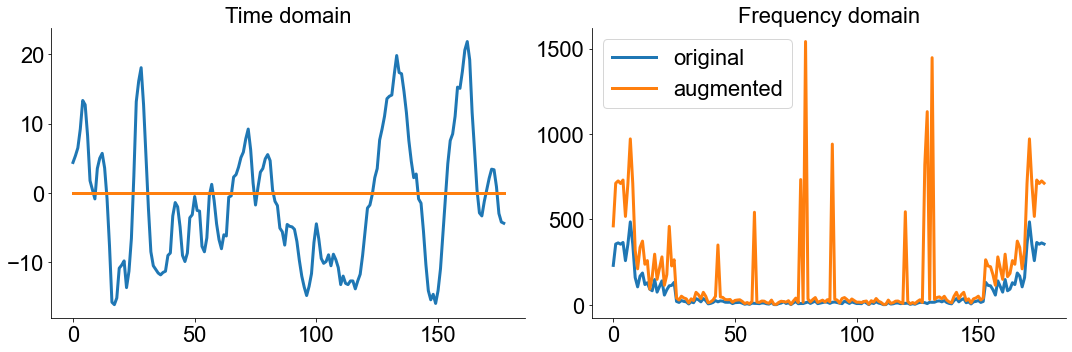

In [45]:
%%time
# inspect data visually


b = next(train_dl_iter)
# 'orig_TD', 'label', 'aug_TD', 'orig_freq', 'aug_freq'

h_t, z_t, h_f, z_f = TFC_model(b[0].to(device), b[3].to(device).float())


item_in_batch_id = 0
fig, (ax, ax1) = plt.subplots(1,2, figsize=(15,5))

item_in_batch = b[0].squeeze().numpy()[item_in_batch_id,:]
ax.plot(item_in_batch, label='original')

item_in_batch = b[2].squeeze().numpy()[item_in_batch_id,:]
ax.plot(item_in_batch, label='augmented')

item_in_batch = b[3].squeeze().numpy()[item_in_batch_id,:]
ax1.plot(item_in_batch, label='original')

item_in_batch = b[4].squeeze().numpy()[item_in_batch_id,:]
ax1.plot(item_in_batch, label='augmented')

ax.set_title('Time domain')
ax1.set_title('Frequency domain')

# ax.legend()
ax1.legend()

# what does <NTXentLoss_poly> do? 

In [46]:
# Contrastive normalized temperature-scaled cross entropy loss

batch_size = configs.batch_size
# instantiate cosine similarity function
get_cosine_similarity = torch.nn.CosineSimilarity(dim=-1) # along the axis that has the same dimensionality

conc = torch.cat([z_t, z_f], dim=0)
# conc = torch.cat([z_f], dim=0)
print(conc.shape)
similarity_matrix = get_cosine_similarity(conc.unsqueeze(1), conc.unsqueeze(0))
print(similarity_matrix.shape)

torch.Size([256, 128])
torch.Size([256, 256])


In [47]:
conc.unsqueeze(1).shape, conc.unsqueeze(0).shape

(torch.Size([256, 1, 128]), torch.Size([1, 256, 128]))

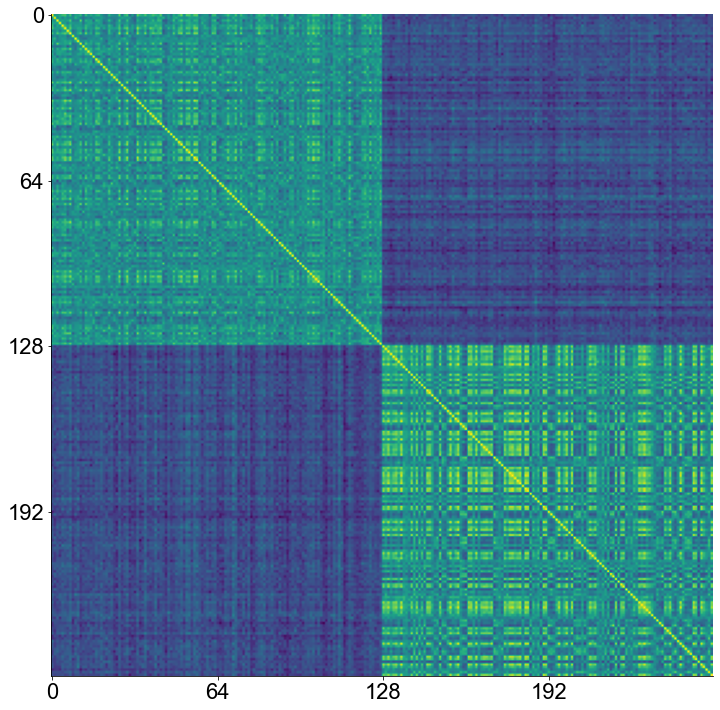

In [48]:
# this is the similarity matrix. is has 4 quadrants: TD-TD, TD-FD, FD-TD, FD-FD

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(similarity_matrix.cpu().detach().numpy())
ax.set_yticks(list(range(0, 256, int(256/4))))
_ = ax.set_xticks(list(range(0, 256, int(256/4))))

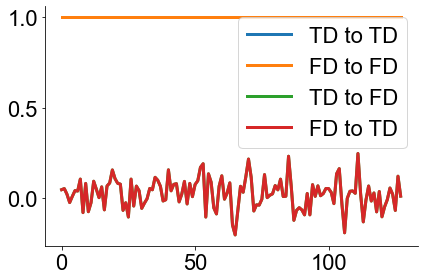

In [49]:
# similarity of TD to FD
plt.plot(torch.diag(similarity_matrix, 0).cpu().detach().numpy()[:batch_size], label='TD to TD')
plt.plot(torch.diag(similarity_matrix, 0).cpu().detach().numpy()[batch_size:], label='FD to FD')
plt.plot(torch.diag(similarity_matrix, batch_size).cpu().detach().numpy(), label='TD to FD')
plt.plot(torch.diag(similarity_matrix, -batch_size).cpu().detach().numpy(), label='FD to TD')
_ = plt.legend()

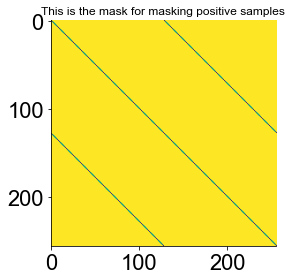

In [50]:
def _get_correlated_mask():
    diag = np.eye(2 * batch_size)
    l1 = np.eye((2 * batch_size), 2 * batch_size, k=-batch_size)
    l2 = np.eye((2 * batch_size), 2 * batch_size, k=batch_size)
    mask = torch.from_numpy((diag + l1 + l2))
    mask = (1 - mask).type(torch.bool)
    return mask.to(device)

mask_samples_from_same_repr = _get_correlated_mask().type(torch.bool)
plt.imshow(mask_samples_from_same_repr.cpu().detach().numpy())
_ = plt.title('This is the mask for masking positive samples', fontsize=12)

In [51]:
# positives are on the 128th diagonal and antidiagonal

l_pos = torch.diag(similarity_matrix, batch_size)
r_pos = torch.diag(similarity_matrix, -batch_size)
positives = torch.cat([l_pos, r_pos]).view(2 * batch_size, 1)

# negatives are everything except the diagonals (we don't care about the main diagonal either, it's always 1 no matter what)
negatives = similarity_matrix[mask_samples_from_same_repr].view(2 * batch_size, -1)

print(f'positives: {positives.shape}, negatives: {negatives.shape}')


positives: torch.Size([256, 1]), negatives: torch.Size([256, 254])


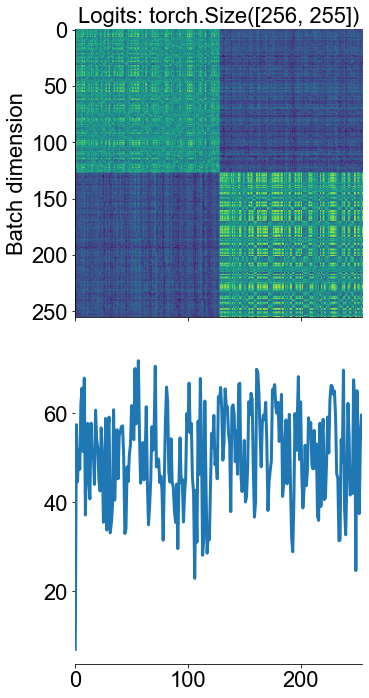

In [52]:
# the sum of the 0-th column is encouraged to be larger than in other columns
# i.e. we want positive samlple embeddings to be more similar that negative samples
# and we do so BY COMPUTING CROSSENTROPY OF EACH ELEENT IN THE BATCH 
# WITH A VECTOR WHOSE 0-TH ELEMENT IS ONE AND ALL OTHERS ARE ZEROS

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(5,10), sharex=True)
logits = torch.cat((positives, negatives), dim=1)
ax.imshow(logits.cpu().detach().numpy())
ax.set_title(f'Logits: {logits.shape}')
ax.set_ylabel('Batch dimension')


ax1.plot(logits[:,].sum(axis=0).cpu().detach().numpy())
ax1.spines['left'].set_visible(False)

In [54]:

labels = torch.zeros(2 * batch_size).to(device).long()
print(f'shape of labels is {labels.shape}')
_criterion = torch.nn.CrossEntropyLoss(reduction="sum")

# zeros in labels will be internally converted by nn.CrossEntropyLoss into one-hot vectors [1, 0, ..., 0]} 
CE = _criterion(logits, labels) # is computed for every item along the batch_dim

shape of labels is torch.Size([256])


In [58]:
CE

tensor(5.7379, device='cuda:1', grad_fn=<NllLossBackward0>)

In [59]:
onehot_label

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:1')

In [56]:
# poly loss is just a term in the overall Xent loss
# softmax each element in the batch, take the mean of the 0-th elements of each softmaxed element

onehot_label = torch.cat(
    (torch.ones(2 * batch_size, 1),
     torch.zeros(2 * batch_size, negatives.shape[-1])),
    dim=-1).to(device).long()

pt = torch.mean(onehot_label * torch.nn.functional.softmax(logits, dim=-1))

print(f'shape of onehot_label is {onehot_label.shape}')
epsilon = 0.2
loss = CE / (2 * batch_size) + epsilon * (1 / batch_size - pt)

shape of onehot_label is torch.Size([256, 255])


# End of explanation

In [ ]:
# pretrain:

TFC_model = TFC(configs).to(device)

TFC_model.train()
model_optimizer = torch.optim.Adam(TFC_model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)

nt_xent_criterion = NTXentLoss_poly(
            device,
            configs.batch_size,
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity)  # device, 128, 0.2, True

EPOCHS = 140
L, total_loss = [], []

for ep in range(EPOCHS):
    for i, (data, labels, aug1, data_f, aug1_f) in enumerate(tqdm(train_dl)):

        data, labels = data.float().to(device), labels.long().to(device)  # data: [128, 1, 178], labels: [128]
        aug1 = aug1.float().to(device)  # aug1 = aug2 : [128, 1, 178]
        data_f, aug1_f = data_f.float().to(device), aug1_f.float().to(device)  # aug1 = aug2 : [128, 1, 178]
        
        model_optimizer.zero_grad()

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = TFC_model(data, data_f)                 # original data
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(aug1, aug1_f) # augmented data



        loss_t = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
        loss_f = nt_xent_criterion(h_f, h_f_aug) # original and perturbed data should be close in FD embedding space

        # time and frequency embeddings should be similar when projected to the joint TF space
        l_TF, l_1, l_2, l_3 = (
            nt_xent_criterion(z_t, z_f),
            nt_xent_criterion(z_t, z_f_aug),
            nt_xent_criterion(z_t_aug, z_f),
            nt_xent_criterion(z_t_aug, z_f_aug))
        
        # Each of the 3 terms below optimize the model towards a smaller l_TF and relatively larger l_(1,2,3)
        loss_c = (1 + l_TF - l_1) + (1 + l_TF - l_2) + (1 + l_TF - l_3) 

        lam = 0.2
        loss = lam * (loss_t + loss_f) + (1 - lam) * loss_c

        total_loss.append(loss.item())

        L.append({'ep': ep,
                  'it': i,
                  'temporal contr. loss': loss_t.item(),
                  'frequency contr. loss': loss_f.item(),
                  'TF consistency loss': l_TF.item(),
                  'TFaug consistency loss': l_1.item(),
                  'TaugF consistency loss': l_2.item(),
                  'TaugFaug consistency loss': l_3.item()})
        loss.backward()
        model_optimizer.step()

 13%|███████████████▎                                                                                                      | 376/2898 [02:03<13:48,  3.04it/s]

In [30]:
h_t.shape, h_t_aug.shape

(torch.Size([128, 1280]), torch.Size([128, 1280]))

In [31]:
h_t.dtype, h_t_aug.dtype

(torch.float32, torch.float32)

In [28]:
# # save model parameters
# torch.save(TFC_model.state_dict(), 'TFC_model.wts')

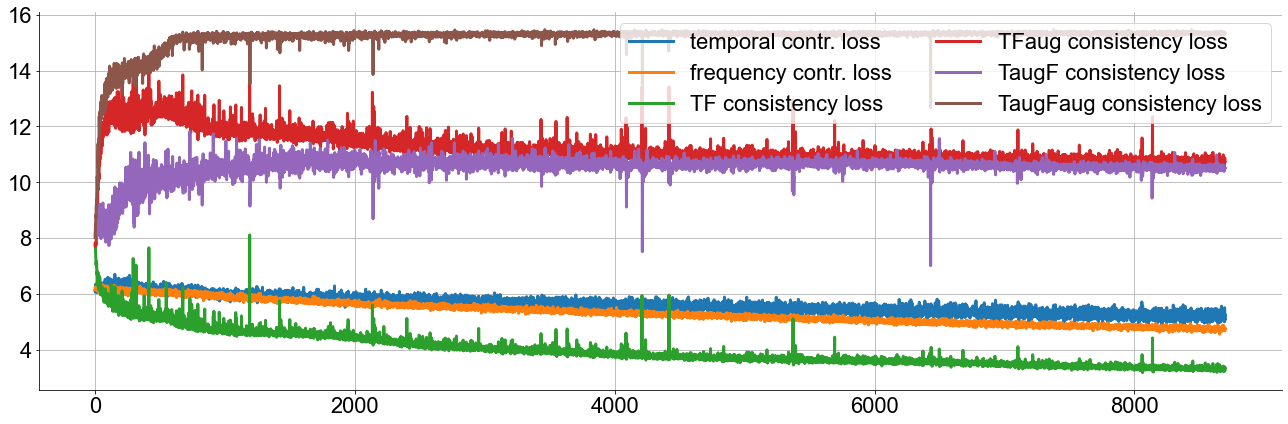

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
pd.DataFrame(L).plot(y=['temporal contr. loss',
                        'frequency contr. loss',
                        'TF consistency loss',
                        'TFaug consistency loss',
                        'TaugF consistency loss',
                        'TaugFaug consistency loss'],
                     ax=ax,
                     legend=None)
ax.legend(ncol=2)
ax.grid()

In [56]:
z_t.shape, h_t.shape

(torch.Size([60, 128]), torch.Size([60, 1280]))

In [215]:
from sklearn.utils.class_weight import compute_class_weight

# a = torch.load(os.path.join(targetdata_path, 'train.pt'))
# class_weights = compute_class_weight('balanced', classes=np.unique(a['labels']), y=a['labels'].tolist())
# class_weights

In [240]:
# fine-tune

# load pre-trained weights
TFC_model.load_state_dict(torch.load('TFC_model_3ep.wts'))
classifier = target_classifier(configs).to(device)

model_optimizer = torch.optim.Adam(TFC_model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)


R = []

nt_xent_criterion = NTXentLoss_poly(
            device,
            60, # batch size
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity)  # device, 128, 0.2, True

classifier = target_classifier(configs).to(device)
criterion = nn.CrossEntropyLoss()


outs = np.array([])
trgs = np.array([])



for ep in range(600):
    
    total_loss = []
    total_acc = []
    total_auc = []
    total_prc = []
    LOSS_P = []
    total_loss_t = [] 
    total_loss_f = []
    
    TFC_model.train()
    classifier.train()

    for data, labels, aug1, data_f, aug1_f in tqdm(valid_dl, bar_format=bar_format):
        
        
        # print('Fine-tuning: {} of target samples'.format(labels.shape[0]))
        data, labels = data.float().to(device), labels.long().to(device)
        data_f = data_f.float().to(device)
        aug1 = aug1.float().to(device)
        aug1_f = aug1_f.float().to(device)

        model_optimizer.zero_grad()
        classifier_optimizer.zero_grad()

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = TFC_model(data, data_f)                 # original data
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(aug1, aug1_f) # augmented data


        loss_t = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
        loss_f = nt_xent_criterion(h_f, h_f_aug) # original and perturbed data should be close in FD embedding space

        # time and frequency embeddings should be similar when projected to the joint TF space
        l_TF, l_1, l_2, l_3 = (
            nt_xent_criterion(z_t, z_f),
            nt_xent_criterion(z_t, z_f_aug),
            nt_xent_criterion(z_t_aug, z_f),
            nt_xent_criterion(z_t_aug, z_f_aug))

        # Each of the 3 terms below optimize the model towards a smaller l_TF and relatively larger l_(1,2,3)
        loss_c = (1 + l_TF - l_1) + (1 + l_TF - l_2) + (1 + l_TF - l_3) 

        """Add supervised classifier: 1) it's unique to finetuning. 2) this classifier will also be used in test"""
        fea_concat = torch.cat((z_t, z_f), dim=1)
        predictions = classifier(fea_concat)  # how to define classifier? MLP? CNN?
        fea_concat_flat = fea_concat.reshape(fea_concat.shape[0], -1)
        loss_p = criterion(predictions, labels)  # predictor loss, actually, here is training loss

        lam = 0.2
        loss = loss_p + (1 - lam) * loss_c + lam * (loss_t + loss_f)

        loss.backward()
        model_optimizer.step()
        classifier_optimizer.step()
        
        acc_bs = labels.eq(predictions.detach().argmax(dim=1)).float().mean().item()
        

        total_acc.append(copy.deepcopy(acc_bs))
        total_auc.append(copy.deepcopy(auc_bs))
        total_prc.append(copy.deepcopy(prc_bs))
        total_loss.append(copy.deepcopy(loss.item()))
        total_loss_t.append(copy.deepcopy(loss_t.item()))
        total_loss_f.append(copy.deepcopy(loss_f.item()))
        LOSS_P.append(copy.deepcopy(loss_p.item()))

        
        

    c_total_acc = test_model(TFC_model, classifier, test_dl)
    
    R.append({
        'finetuning_acc': copy.deepcopy(np.mean(total_acc)),
        'testing_acc': copy.deepcopy(np.mean(c_total_acc)),
        'ft_loss': copy.deepcopy(np.mean(LOSS_P)),
        'total_loss_t': copy.deepcopy(np.mean(total_loss_t)),
        'total_loss_f': copy.deepcopy(np.mean(total_loss_f))})
df = pd.DataFrame(R)


100%|██████████| 190/190 [00:00<00:00, 475.35it/s]                                                                                                            


100%|██████████| 190/190 [00:00<00:00, 478.83it/s]                                                                                                            


100%|██████████| 190/190 [00:00<00:00, 479.94it/s]                                                                                                            


100%|██████████| 190/190 [00:00<00:00, 474.72it/s]                                                                                                            


100%|██████████| 190/190 [00:00<00:00, 474.39it/s]                                                                                                            


100%|██████████| 190/190 [00:00<00:00, 482.93it/s]                                                                                                            


100%|██████████| 190/190 [00:00<00:00, 464.52it/s]                                                                                                            


 18%|█▊        | 35/190 [00:00<00:00, 486.30it/s]                                                                                                             


KeyboardInterrupt: 

In [241]:
df = pd.DataFrame(R)

<AxesSubplot:>

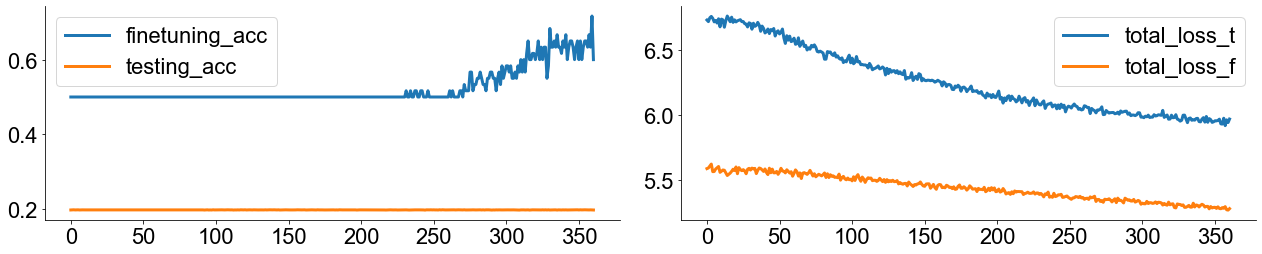

In [242]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
df.plot(y=['finetuning_acc', 'testing_acc'], ax=ax[0])
df.plot(y=['total_loss_t', 'total_loss_f'], ax=ax[1])
# ax[0].set_xlim(1, 9)
# ax[1].set_xlim(1, 9)

In [155]:
def test_model(model, classifier, test_dl):
    model.eval()
    classifier.eval()

    ACC = []
    
    for data, labels, aug1, data_f, aug1_f in tqdm(test_dl, bar_format=bar_format):
        with torch.no_grad():
            data = data.float().to(device)
            labels = labels.long().to(device)
            data_f = data_f.float().to(device)


            # embed time representation and frequency representations (h). Z's are projections into joint TF space
            h_t, z_t, h_f, z_f = model(data, data_f)                 # original data


            fea_concat = torch.cat((z_t, z_f), dim=1)
            predictions = classifier(fea_concat)


            acc_bs = labels.eq(predictions.detach().argmax(dim=1)).float().mean().item()

            ACC.append(acc_bs)
    
    return np.mean(ACC)

In [181]:
R = []

for i, (data, labels, aug1, data_f, aug1_f) in tqdm(enumerate(test_dl), bar_format=bar_format):
    data, labels = data.float().to(device), labels.long().to(device)
    data_f = data_f.float().to(device)

    # embed time representation and frequency representations (h). Z's are projections into joint TF space
    h_t, z_t, h_f, z_f = TFC_model(data, data_f)                 # original dat


    fea_concat = torch.cat((z_t, z_f), dim=1)
    predictions = classifier(fea_concat)
    
    R.append({'batch': i,
              'mean_pred': predictions.argmax(axis=1).float().mean().item(),
              'mean_label': labels.float().mean().item()})
R = pd.DataFrame(R)

|          | 190/? [00:00<00:00, 443.67it/s]                                                                                                                  


<AxesSubplot:>

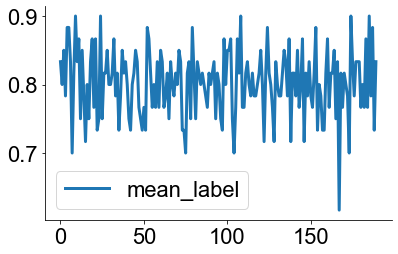

In [182]:
R.plot(y=['mean_label'])

1.0